In [19]:
import qiskit
# %matplotlib notebook
%matplotlib inline

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit import IBMQ
from qiskit import Aer,BasicAer, execute, assemble
from qiskit.providers.aer import AerSimulator
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error,phase_damping_error


# Needed for functions
import time
from copy import deepcopy
import numpy as np
from numpy import pi

import matplotlib as mpl
# mpl.use('TkAgg')
import matplotlib.pyplot as plt

from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.visualization import plot_bloch_multivector

import qiskit.quantum_info as qi
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import partial_trace, Statevector

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

# Auxiliary methods
from qiskit.quantum_info import Choi, Kraus
from qiskit.extensions import HGate, XGate

In [107]:
Circits = []
Ideal_states = []


for i in range(0,5):
    # Create the expected statevector
    q2 = QuantumRegister(2)
    idcr = QuantumCircuit(q2)
    idcr.x(q2[0])
    for k in range(0,i+1):
        idcr.cx(q2[k%2], q2[1-k%2])

    Ideal_states.append(qi.Statevector.from_instruction(idcr))
    
    # Create the actual circuit 
    q2 = QuantumRegister(3)
    circ = QuantumCircuit(q2)
    circ.x(q2[0])
    for k in range(0,i+1):
        circ.cx(q2[k%2], q2[1-k%2])
    
    Circits.append(circ)
    
# for i in range(0,3):
#     # Create the expected statevector
#     q2 = QuantumRegister(3)
#     idcr = QuantumCircuit(q2)
#     # idcr.h(q2[0])
#     for k in range(0,i+1):
#         idcr.cx(q2[k%2+1], q2[1-k%2+1])

#     Ideal_states.append(qi.Statevector.from_instruction(idcr))
    
#     # Create the actual circuit 
#     q2 = QuantumRegister(3)
#     circ = QuantumCircuit(q2)
#     # circ.h(q2[0])
#     for k in range(0,i+1):
#         circ.cx(q2[k%2+1], q2[1-k%2+1])
    
#     Circits.append(circ)    
    


In [29]:
Ideal_states[4]

Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


In [108]:
results = []

In [109]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_lima')

ibmqfactory.load_account:WARNING:2022-04-12 13:23:00,995: Credentials are already in use. The existing account in the session will be replaced.


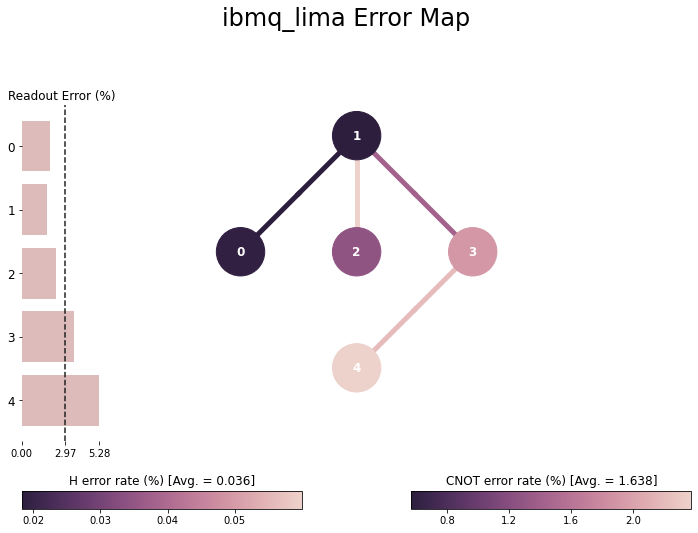

In [110]:
qiskit.visualization.plot_error_map(backend)

In [111]:
Qst_circ = []
Tomo_fitter_circ = []
Meas_fitter = []
Correct_tomo_results=[]
# Generate circuits and run on simulator
t = time.time()


    
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1])

# meas_calibs1, state_labels1 = mc.complete_meas_cal(qubit_list=[0,1])



# Generate the state tomography circuits.
for circ in  Circits:
    Qst_circ.append( state_tomography_circuits(circ, [0, 1]) )
    
# delete from here    
qlist = []
for  qst_circ in  Qst_circ:
    for qcir in qst_circ:
        qlist.append(qcir)

job_tomo = qiskit.execute(qlist, backend=backend, shots=4000)
results.append(job_tomo)
job_cal = qiskit.execute(meas_calibs, backend=backend, shots=4000)
results.append(job_cal)

for  i in range(0, len(Qst_circ)):
    test = qiskit.result.result.Result(backend_name=job_tomo.result().backend_name , backend_version =job_tomo.result().backend_version \
                                   , qobj_id=job_tomo.result().qobj_id, job_id=job_tomo.result().job_id\
                                   , success=job_tomo.result().success, results=job_tomo.result().results[i*len(Qst_circ[0]):(i+1)*len(Qst_circ[0])] )
    Tomo_fitter_circ.append( StateTomographyFitter(test, Qst_circ[i]) )
    Meas_fitter.append(mc.CompleteMeasFitter(job_cal.result(),state_labels))
    Correct_tomo_results.append(Meas_fitter[len(Meas_fitter)-1].filter.apply(test, method='least_squares'))
print('For Time taken:', time.time() - t)

    
    

For Time taken: 275.355836391449


In [112]:
Rho_circ = []

for i in range (0,len(Tomo_fitter_circ)) :
    # Perform the tomography fit
    # which outputs a density matrix
    rho_circ = Tomo_fitter_circ[i].fit(method='lstsq')
    Rho_circ.append(rho_circ)
    F_circ = qi.state_fidelity(rho_circ,Ideal_states[i])
    print('State fidelity (no correction): F = {:.5f}'.format(F_circ))

State fidelity (no correction): F = 0.91321
State fidelity (no correction): F = 0.93767
State fidelity (no correction): F = 0.92466
State fidelity (no correction): F = 0.88577
State fidelity (no correction): F = 0.93282


In [113]:
Rho_fit_circ_mit = []

for i in range (0,len(Tomo_fitter_circ)): #correct data
    tomo_circ_mit = StateTomographyFitter(Correct_tomo_results[i], Qst_circ[i])
    rho_fit_circ_mit = tomo_circ_mit.fit(method='lstsq')
    Rho_fit_circ_mit.append(rho_fit_circ_mit)
    F_circ_mit = qi.state_fidelity(rho_fit_circ_mit, Ideal_states[i])
    print('State fidelity (w/ correction): F = {:.5f}'.format(F_circ_mit))

State fidelity (w/ correction): F = 0.98971
State fidelity (w/ correction): F = 0.98737
State fidelity (w/ correction): F = 0.97845
State fidelity (w/ correction): F = 0.96237
State fidelity (w/ correction): F = 0.97258


In [116]:
rho = qi.DensityMatrix(Rho_fit_circ_mit[2])
rho.draw('latex', prefix='\\rho_{AB} = ')

<IPython.core.display.Latex object>

In [1]:
rho = qi.DensityMatrix(Rho_fit_circ_mit[4])
plot_bloch_multivector(rho.data)

NameError: name 'qi' is not defined

In [35]:
import datetime

timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)
timestr=timestr+'.txt'

with open(timestr, 'w') as f:
    details = results[0].result().to_dict()
    for key, value in details.items(): 
        f.write('%s:%s\n' % (key, value))
    details = results[1].result().to_dict()
    for key, value in details.items(): 
        f.write('%s:%s\n' % (key, value))
      

2022-04-11 23:13:02.653601


In [21]:

sim_limo = AerSimulator.from_backend(backend)


In [35]:
Qst_circ = []
Tomo_fitter_circ = []
Meas_fitter = []
Correct_tomo_results=[]
# Generate circuits and run on simulator
t = time.time()


JOB = []
    
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1])

# meas_calibs1, state_labels1 = mc.complete_meas_cal(qubit_list=[0,1])



# Generate the state tomography circuits.
for circ in  Circits:
    Qst_circ.append( state_tomography_circuits(circ, [0,1]) )
    
job_cal = qiskit.execute(meas_calibs, backend=sim_limo, shots=4000)
for  qst_circ in  Qst_circ:
    # Execute
    job_tomo = qiskit.execute(qst_circ, backend=sim_limo, shots=4000)
    JOB.append(job_tomo)
    # Fit result
    Tomo_fitter_circ.append(StateTomographyFitter(job_tomo.result(), qst_circ))
    
    Meas_fitter.append(mc.CompleteMeasFitter(job_cal.result(),state_labels))
    
    Correct_tomo_results.append(Meas_fitter[len(Meas_fitter)-1].filter.apply(job_tomo.result(), method='least_squares'))
print('For Time taken:', time.time() - t)
    
    

For Time taken: 4.4441819190979


In [101]:

Qst_circ = []
Tomo_fitter_circ = []
Meas_fitter = []
Correct_tomo_results=[]
# Generate circuits and run on simulator
t = time.time()


JOB1 = []
    
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1])

# Generate the state tomography circuits.
for circ in  Circits:
    Qst_circ.append( state_tomography_circuits(circ, [0,1]) )

# delete from here    
qlist = []
for  qst_circ in  Qst_circ:
    for qcir in qst_circ:
        qlist.append(qcir)

        
job_tomo = qiskit.execute(qlist, backend=sim_limo, shots=4000)

job_cal = qiskit.execute(meas_calibs, backend=sim_limo, shots=4000)


for  i in range(0, len(Qst_circ)):
    test = qiskit.result.result.Result(backend_name=job_tomo.result().backend_name , backend_version =job_tomo.result().backend_version \
                                   , qobj_id=job_tomo.result().qobj_id, job_id=job_tomo.result().job_id\
                                   , success=job_tomo.result().success, results=job_tomo.result().results[i*len(Qst_circ[0]):(i+1)*len(Qst_circ[0])] )
    Tomo_fitter_circ.append( StateTomographyFitter(test, qlist[i:i+len(Qst_circ[0])]) )
    JOB1.append(test)
    Meas_fitter.append(mc.CompleteMeasFitter(job_cal.result(),state_labels))
    Correct_tomo_results.append(Meas_fitter[len(Meas_fitter)-1].filter.apply(test, method='least_squares'))
print('For Time taken:', time.time() - t)

For Time taken: 4.117482662200928


In [102]:
Rho_circ = []

for i in range (0,len(Tomo_fitter_circ)) :
    # Perform the tomography fit
    # which outputs a density matrix
    rho_circ = Tomo_fitter_circ[i].fit(method='lstsq')
    Rho_circ.append(rho_circ)
    F_circ = qi.state_fidelity(rho_circ,Ideal_states[i])
    print('State fidelity (no correction): F = {:.5f}'.format(F_circ))

State fidelity (no correction): F = 0.94061
State fidelity (no correction): F = 0.95343
State fidelity (no correction): F = 0.94834
State fidelity (no correction): F = 0.91778
State fidelity (no correction): F = 0.92766
